In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import utils as ut

DATA_PATH = '../../datav2/esp/'

%load_ext autoreload
%autoreload 2

In [2]:
df = ut.load_data(DATA_PATH,'train',nclasses=5).loc[:,['review_content','review_rate']]
df.head(5)

Dataset cargado para 5 clases (muy malo=1, malo=2, medio=3, bueno=4 muy bueno=5)
Num samples per category:
1    92477
2    92449
3    92487
4    92501
5    92454
Name: review_rate, dtype: int64


,review_content,review_rate
0,"Esta de muy baja calidad, no fue lo esperado.",2
1,"Reconozco que fue muy económico, pero su durab...",2
2,Muy bien muy bien muy bien muy bien muy bien m...,5
3,No me fue útil para mí. Diseño muy bueno.,2
4,No fue lo estipulado. Solo eso voy aclarar.,1


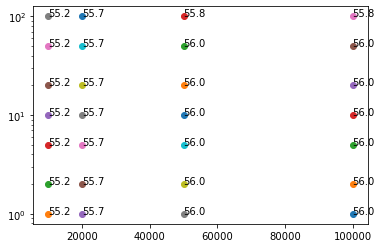

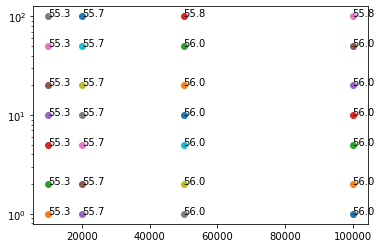

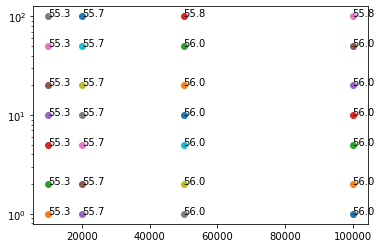

In [19]:
import os
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score

max_words = [100000, 50000, 20000, 10000]
freq_cutoff = [1, 2, 5, 10, 20, 50, 100]
tokenizers = ['regex', 'nltk', 'tweet']

for tok in tokenizers:
    fig, ax = plt.subplots()
    for mw in max_words:
        for fc in freq_cutoff:
            with open('./results_hyper_search/nb_classification_5_classes_mw{}_fc{}.pkl'.format(mw,fc), 'rb') as f:
                data = pickle.load(f)
            y = data[tok]['y']
            y_pred = data[tok]['y_pred']
            acc = accuracy_score(y,y_pred)
            ax.plot(mw,fc,'o')
            ax.set_yscale('log')
            ax.annotate('{:.1f}'.format(acc*100),(mw,fc))
    fig.show()
    

Elegimos el siguiente modelo:

* Tokenización con la siguiente regular expression: `(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)`
* Vectorización por bolsa de palabras con bigramas y unigramas
* Reponderamiento TF-IDF
* Límite de features: 50000
* Sin límite de frecuencia por feature

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pickle

def normalize_dataset(df):
    # Pasamos a minúscula todo
    df['review_content'] = df['review_content'].str.lower()
    # Sacamos todos los acentos
    for rep, rep_with in [('[óòÓöøôõ]','o'), ('[áàÁäåâãÄ]','a'), ('[íìÍïîÏ]','i'), 
                          ('[éèÉëêÈ]','e'), ('[úüÚùûÜ]','u'), ('[ç¢Ç]','c'), 
                          ('[ý¥]','y'),('š','s'),('ß','b'),('\x08','')]:
        df['review_content']  = df['review_content'].str.replace(rep,rep_with,regex=True)
    return df

results = {}
for n_classes in [2,3,5]:
    df_train = ut.load_data(DATA_PATH,'train',nclasses=n_classes).loc[:,['review_content','review_rate']]
    df_test = ut.load_data(DATA_PATH,'test',nclasses=n_classes).loc[:,['review_content','review_rate']]
    df_train = normalize_dataset(df_train)
    df_test = normalize_dataset(df_test)
    vec = TfidfVectorizer(token_pattern=r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)',
                        ngram_range=(1,2),max_features=50000)
    clf = MultinomialNB(alpha=1.0)

    results_frac = {}
    for frac in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]:
        print('nclasses: {}. frac: {:.5}.'.format(n_classes,frac))
        # Train:
        df_train_part = df_train.sample(frac=frac,random_state=632147)
        X_train = vec.fit_transform(df_train_part['review_content'])
        y_train = df_train_part['review_rate'].values
        clf.fit(X_train,y_train)
        # Predict:
        X_test = vec.transform(df_test['review_content'])
        y_pred = clf.predict(X_test)
        y_test = df_test['review_rate']
        results_frac[frac] = {
            'acc': accuracy_score(y_test,y_pred),
            #'f1_score': f1_score(y_test,y_pred),
            'confusion_matrix': confusion_matrix(y_test,y_pred)
        }
    results[n_classes] = results_frac

with open('results_test.pkl','wb') as f:
    pickle.dump(results,f)

    

Dataset cargado para 2 clases (malo=0, bueno=1)
Num samples per category:
0    184926
1    184955
Name: review_rate, dtype: int64
Dataset cargado para 2 clases (malo=0, bueno=1)
Num samples per category:
0    10000
1    10000
Name: review_rate, dtype: int64
nclasses: 2. frac: 0.0001.
nclasses: 2. frac: 0.0005.
nclasses: 2. frac: 0.001.
nclasses: 2. frac: 0.005.
nclasses: 2. frac: 0.01.
nclasses: 2. frac: 0.05.
nclasses: 2. frac: 0.1.
nclasses: 2. frac: 0.5.
nclasses: 2. frac: 1.0.
Dataset cargado para 3 clases (malo=0, medio=1, bueno=2)
Num samples per category:
0    184926
1     92487
2    184955
Name: review_rate, dtype: int64
Dataset cargado para 3 clases (malo=0, medio=1, bueno=2)
Num samples per category:
0    10000
1     5000
2    10000
Name: review_rate, dtype: int64
nclasses: 3. frac: 0.0001.
nclasses: 3. frac: 0.0005.
nclasses: 3. frac: 0.001.
nclasses: 3. frac: 0.005.
nclasses: 3. frac: 0.01.
nclasses: 3. frac: 0.05.
nclasses: 3. frac: 0.1.
nclasses: 3. frac: 0.5.
nclasses: 3

Dataset cargado para 2 clases (malo=0, bueno=1)
Num samples per category:
0    10000
1    10000
Name: review_rate, dtype: int64
Dataset cargado para 3 clases (malo=0, medio=1, bueno=2)
Num samples per category:
0    10000
1     5000
2    10000
Name: review_rate, dtype: int64
Dataset cargado para 5 clases (muy malo=1, malo=2, medio=3, bueno=4 muy bueno=5)
Num samples per category:
1    5000
2    5000
3    5000
4    5000
5    5000
Name: review_rate, dtype: int64


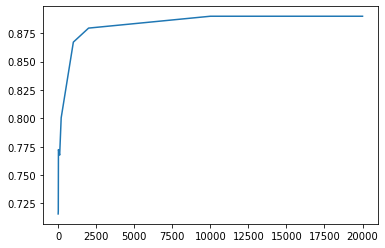

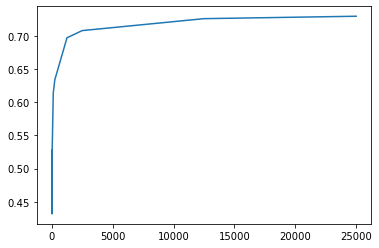

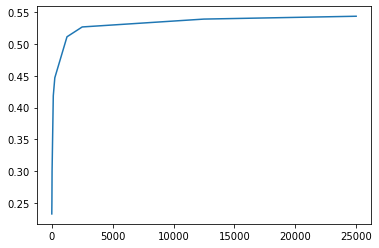

In [12]:
with open('results_test.pkl','rb') as f:
    results = pickle.load(f)

for n_classes in [2,3,5]:
    df_test = ut.load_data(DATA_PATH,'test',nclasses=n_classes).loc[:,['review_content','review_rate']]
    N_samples_tot = len(df_test)
    N_samples = []
    accuracies = []
    for frac, scores in results[n_classes].items():
        N_samples.append(int(frac * N_samples_tot))
        accuracies.append(scores['acc'])

    fig, ax = plt.subplots()
    ax.plot(N_samples,accuracies)
    #ax.set_xscale('log')

In [17]:
for n in [2,3,5]:
    print('Accuracy para {} clases con todo el train set: {:.2f}%'.format(n,
        results[n][1.]['acc']*100))

Accuracy para 2 clases con todo el train set: 89.00%
Accuracy para 3 clases con todo el train set: 72.98%
Accuracy para 5 clases con todo el train set: 54.40%
